### Imports

In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

import os

import torch
import base64

import numpy as np
import supervision as sv

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from colorthief import ColorThief
import matplotlib.pyplot as plt
import colorsys

from jupyter_bbox_widget import BBoxWidget

In [ ]:
os.environ["GOOGLE_API_KEY"] = "YOUR API KEY"
from langchain import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import LLMChain


In [3]:
import torchvision.models as models
import torch.nn as nn
from PIL import Image
from torchvision import transforms

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [4]:
from skimage import exposure, img_as_ubyte
from skimage.metrics import structural_similarity as ssim
from skimage import exposure, img_as_ubyte, transform

### Cuda Things

In [5]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()            # Enable bfloat16 (AMP) support

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = "/mnt/e/projects/img_seg/segment-anything-2/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"
print("DEVICE:", DEVICE)
sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)

DEVICE: cuda


### Loading Models

In [7]:
model = YOLO('yolov8n.pt')
predictor = SAM2ImagePredictor(sam2_model)

100%|██████████| 6.25M/6.25M [00:00<00:00, 14.2MB/s]


In [8]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                            verbose=True,
                            temperature=0.7,
                            google_api_key=os.getenv("GOOGLE_API_KEY"))

In [9]:
# Load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# Remove the final classification layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Set the model to evaluation mode (no training, just feature extraction)
resnet.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### User Defined Functions

In [10]:
desired_resolution = 416

In [11]:
def convert_to_widget_bbox(detection_roi):
    x_min, y_min, x_max, y_max = detection_roi
    width = x_max - x_min
    height = y_max - y_min
    return {'x': x_min, 'y': y_min, 'width': width, 'height': height, 'label': ''}

In [12]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [13]:
def plot_segmentation(image, masks):
    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks),
        mask=masks.astype(bool)
    )

    source_image = box_annotator.annotate(scene=image.copy(), detections=detections)
    segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

    sv.plot_images_grid(
        images=[source_image, segmented_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )

In [14]:
def get_color(masks, image_rgb):
    colors = []
    for i in range(masks.shape[0]):
        object_mask = masks[i].astype(bool)  # Convert the mask to boolean
        object_pixels = image_rgb[object_mask]  # Extract RGB values of the masked area

        # Calculate the dominant color or mean color
        mean_color = np.mean(object_pixels, axis=0)  # Calculate the average color
        unique_colors, counts = np.unique(object_pixels, axis=0, return_counts=True)
        dominant_color = unique_colors[np.argmax(counts)]  # Find the most frequent color
        # colors.append([dominant_color, mean_color])
        colors.append(dominant_color)
    return colors

In [15]:
def get_bg_color(image_rgb, masks):
    background_mask = np.logical_not(np.any(masks, axis=0))
    background_pixels = image_rgb[background_mask]
    mean_background_color = np.mean(background_pixels, axis=0)
    return mean_background_color

In [16]:
def get_objects(image, IMAGE_PATH):   
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model(image, imgsz=desired_resolution, conf = 0.25)
    annotated_image = results[0].plot()
    detections = sv.Detections.from_ultralytics(results[0])
    labels = [
                model.model.names[class_id]
                for class_id
                in detections.class_id
            ]
    widget = BBoxWidget() 
    for i in range(len(detections.xyxy)):
        widget_bbox = convert_to_widget_bbox(detections.xyxy[i])
                              # Create a new BBoxWidget
        widget.image = encode_image(IMAGE_PATH)
        widget.bboxes.append(widget_bbox)
    boxes = widget.bboxes

    boxes = np.array([              # Convert the widget bboxes to a numpy array
        [
            box['x'],
            box['y'],
            box['x'] + box['width'],
            box['y'] + box['height']
        ] for box in boxes
    ])

    predictor.set_image(image_rgb)          # Set the image for the predictor

    masks, scores, logits = predictor.predict(          # Predict the masks
        box=boxes,
        multimask_output=False
    )
    if len(widget.bboxes) > 1:
        masks = np.squeeze(masks)
    return masks, labels, detections, annotated_image

In [17]:

def get_color_names(labels, obj_colors):
    obj = ()
    color_obj = ()
    labels_with_colors = list(zip(labels, obj_colors))
    template = '''
    Given the RGB color values in {color_obj}, return the most accurate color name based on the RGB value of the corresponding object that is {obj}.
    You shall only return the name nothing else.
    '''
    prompt = PromptTemplate(
        input_variables=['color_obj', 'obj'],
        template=template
    )

    prompt.format(color_obj=color_obj,obj=obj)

    # chian1 = LLMChain(llm=llm, prompt=prompt)
    sequence = prompt | llm

    updated_labels_with_colors = []
    for obj in labels_with_colors:
        response = sequence.invoke({
            "color_obj": obj[1].tolist(),  # Convert numpy array to list for JSON serialization
            "obj" : obj[0]
        })
        color_name = response.content.strip()  # Get the color name from the response
        updated_labels_with_colors.append((obj[0], color_name))

    return updated_labels_with_colors


In [18]:
def gen_prompt(updated_labels_with_colors, bg_color):    
    template = '''
    Generate an image prompt using the following details:
    - Objects and their colors: {labels_with_colors}
    - Background color (in RGB format): {bg_color}

    Each object color is provided as an RGB value, so use the closest color name for the object. The background color is also provided as an RGB value; use the closest color name for the background.
    Also try to include the quanitity of the object along with the associated object. example: generate a photorealistic image of only 1 yellow banana with 1 red apple
    Just provide the text for the image generation prompt. Do not mix multiple colors for the background if only one RGB value is given.
    '''
    prompt = PromptTemplate(
        input_variables=['labels_with_colors', 'bg_color'],
        template=template
    )

    prompt.format(labels_with_colors=updated_labels_with_colors, bg_color=bg_color)
    # chian1 = LLMChain(llm=llm, prompt=prompt)
    sequence = prompt | llm
    prompt.format(labels_with_colors=updated_labels_with_colors, bg_color=bg_color)
    response = sequence.invoke({
        "labels_with_colors": updated_labels_with_colors,
        "bg_color": bg_color
    })
    prompt = response.content
    return prompt

In [19]:
from collections import Counter

def calculate_similarity(labels1, labels2):
    """
    Calculate the percentage of similarity between two lists of labels.

    Args:
    labels1 (list): List of labels for the first image.
    labels2 (list): List of labels for the second image.

    Returns:
    float: Percentage of similarity between the two lists of labels.
    """
    # Count the occurrences of each label in both lists
    counter1 = Counter(labels1)
    counter2 = Counter(labels2)

    # Calculate the total number of labels in each list
    total_labels1 = sum(counter1.values())
    total_labels2 = sum(counter2.values())

    # Calculate the number of matching labels and their counts
    common_labels = counter1 & counter2  # Intersection: min(count1, count2) for each label
    matching_count = sum(common_labels.values())

    # Calculate the similarity percentage
    total_labels = total_labels1 + total_labels2
    if total_labels == 0:
        return 0.0  # Avoid division by zero if both lists are empty

    similarity_percentage = (2 * matching_count / total_labels) * 100

    return similarity_percentage

In [20]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from PIL import Image

def divide_into_patches(image, mask, num_patches):
    """
    Divide the masked region of an image into a fixed number of patches.

    Args:
    image (numpy.ndarray): The input image.
    mask (numpy.ndarray): The binary mask for the object.
    num_patches (int): The number of patches to divide the mask into (both horizontally and vertically).

    Returns:
    list: List of patches as numpy arrays.
    """
    patches = []
    h, w = mask.shape
    patch_h, patch_w = h // num_patches, w // num_patches

    for i in range(num_patches):
        for j in range(num_patches):
            patch_mask = mask[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w]
            patch_image = image[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w]
            patch = cv2.bitwise_and(patch_image, patch_image, mask=patch_mask.astype(np.uint8))
            patches.append(patch)
    
    return patches

def compute_lbp(image, P=8, R=1):
    """
    Compute the Local Binary Pattern (LBP) texture matrix for an image.

    Args:
    image (numpy.ndarray): The input image.
    P (int): Number of circularly symmetric neighbor set points (default is 8).
    R (float): Radius of circle (default is 1).

    Returns:
    numpy.ndarray: The LBP texture matrix.
    """
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, P, R, method='uniform')
    return lbp

def compute_lbp_histogram(lbp_matrix, num_bins=256):
    """
    Compute the histogram of LBP values.

    Args:
    lbp_matrix (numpy.ndarray): The LBP texture matrix.
    num_bins (int): Number of bins for the histogram.

    Returns:
    numpy.ndarray: The histogram of LBP values.
    """
    hist, _ = np.histogram(lbp_matrix.ravel(), bins=num_bins, range=(0, num_bins), density=True)
    return hist

def get_lbp_for_objects_with_patches(image, masks, labels_with_colors, num_patches, num_bins=256):
    """
    Get the aggregated LBP histogram for each object in an image and associate it with the respective label and color.

    Args:
    image (numpy.ndarray): The input image.
    masks (list): List of masks, each represented as a binary numpy array.
    labels_with_colors (list): List of tuples (label, color) corresponding to each mask.
    num_patches (int): The number of patches to divide each mask into (both horizontally and vertically).
    num_bins (int): Number of bins for the LBP histogram.

    Returns:
    dict: Dictionary where each (label, color) tuple is associated with its aggregated LBP histogram.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)
        
    lbp_dict = {}
    for mask, (label, color) in zip(masks, labels_with_colors):
        patches = divide_into_patches(image, mask, num_patches)
        lbp_histograms = [compute_lbp_histogram(compute_lbp(patch), num_bins) for patch in patches]
        aggregated_histogram = np.sum(lbp_histograms, axis=0)
        lbp_dict[(label, color)] = aggregated_histogram[:10]
    return lbp_dict

def chi_square_distance(hist1, hist2):
    """
    Compute the Chi-Square distance between two histograms.
    
    Args:
    hist1 (numpy.ndarray): First histogram.
    hist2 (numpy.ndarray): Second histogram.
    
    Returns:
    float: Chi-Square distance.
    """
    return 0.5 * np.sum(((hist1 - hist2) ** 2) / (hist1 + hist2 + 1e-10))

def calculate_similarity_score(lbp_dict1, lbp_dict2):
    """
    Calculate the similarity score between two sets of LBP histograms.
    
    Args:
    lbp_dict1 (dict): Dictionary of LBP histograms for the first image.
    lbp_dict2 (dict): Dictionary of LBP histograms for the second image.
    
    Returns:
    float: Aggregated similarity score.
    """
    total_score = 0
    common_keys = set(lbp_dict1.keys()).intersection(set(lbp_dict2.keys()))
    
    for key in common_keys:
        hist1 = lbp_dict1[key]
        hist2 = lbp_dict2[key]
        score = chi_square_distance(hist1, hist2)
        total_score += score
    
    # Normalize the score by the number of common keys
    if common_keys:
        total_score /= len(common_keys)
    
    similarity_score = 1 / (1 + total_score)
    return similarity_score

In [21]:
def get_texture_sim(image, gen_image, labels_with_colors, gen_labels_with_colors, masks, gen_masks, num_patches=4):
    """
    Calculate the similarity score between two images based on their texture using Local Binary Patterns (LBP).

    Args:
    image1 (numpy.ndarray): The first input image.
    image2 (numpy.ndarray): The second input image.
    num_patches (int): The number of patches to divide each mask into (both horizontally and vertically).

    Returns:
    float: The similarity score between the two images based on texture.
    """
    lbp_dict1 = get_lbp_for_objects_with_patches(image, masks, labels_with_colors,  num_patches)
    lbp_dict2 = get_lbp_for_objects_with_patches(gen_image, gen_masks, gen_labels_with_colors, num_patches)

    return calculate_similarity_score(lbp_dict1, lbp_dict2)

In [22]:
def get_features(image_path):
# Image preprocessing (resize, normalize)
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),   # ResNet requires input images of size 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the image
    image = Image.open(image_path)

    # Preprocess the image
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

    # Extract features from the image
    with torch.no_grad():
        features = resnet(image_tensor).squeeze()

    # Convert the feature map to a numpy array if needed
    features = features.numpy()
    return features


In [23]:
def get_restnet_sim(image_path, gen_image_path):
    features_original = get_features(image_path)
    features_generated = get_features(gen_image_path)
    similarity_score = cosine_similarity(features_original.reshape(1, -1), features_generated.reshape(1, -1))
    return similarity_score[0][0]

In [24]:
def compare_local_contrast(image1, image2):
    # Extract the a and b channels
    lab_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2LAB)
    lab_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2LAB)    
    a_channel1 = lab_image1[:, :, 1]
    b_channel1 = lab_image1[:, :, 2]

    a_channel2 = lab_image2[:, :, 1]
    b_channel2 = lab_image2[:, :, 2]

    # Combine the channels to create grayscale images that reflect color contrast
    color_contrast_image1 = np.sqrt(a_channel1**2 + b_channel1**2)
    color_contrast_image2 = np.sqrt(a_channel2**2 + b_channel2**2)

    # Check for empty arrays
    if color_contrast_image1.size == 0 or color_contrast_image2.size == 0:
        raise ValueError("One of the color contrast images is empty.")

    # Check for NaN or Inf values
    if np.isnan(color_contrast_image1).any() or np.isnan(color_contrast_image2).any():
        raise ValueError("One of the color contrast images contains NaN values.")
    if np.isinf(color_contrast_image1).any() or np.isinf(color_contrast_image2).any():
        raise ValueError("One of the color contrast images contains Inf values.")

    # Convert to float32 for normalization
    color_contrast_image1 = color_contrast_image1.astype(np.float32)
    color_contrast_image2 = color_contrast_image2.astype(np.float32)

    # Normalize to the range [0, 1] for better visualization using skimage
    color_contrast_image1 = exposure.rescale_intensity(color_contrast_image1, in_range='image', out_range=(0, 1))
    color_contrast_image2 = exposure.rescale_intensity(color_contrast_image2, in_range='image', out_range=(0, 1))

        # Resize images to the same dimensions
    target_shape = (min(color_contrast_image1.shape[0], color_contrast_image2.shape[0]),
                    min(color_contrast_image1.shape[1], color_contrast_image2.shape[1]))
    color_contrast_image1 = transform.resize(color_contrast_image1, target_shape, anti_aliasing=True)
    color_contrast_image2 = transform.resize(color_contrast_image2, target_shape, anti_aliasing=True)

    # Convert to uint8 for visualization
    color_contrast_image1 = img_as_ubyte(color_contrast_image1)
    color_contrast_image2 = img_as_ubyte(color_contrast_image2)

    # Display the contrast maps (color contrast in grayscale) using matplotlib
    ssim_contrast, _ = ssim(color_contrast_image1, color_contrast_image2, full=True)

    return ssim_contrast, color_contrast_image1, color_contrast_image2

In [25]:
def plot_contrast_images(image1, image2, cmap, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(title + ': Image 1')
    plt.imshow(image1, cmap = cmap)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title +': Image 2')
    plt.imshow(image2, cmap = cmap)
    plt.axis('off')

    plt.show()  

In [26]:
def compare_global_contrast(image1, image2):
# Compute the standard deviation for the a and b channels
    lab_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2LAB)
    lab_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2LAB)
    std_a_image1 = np.std(lab_image1[:, :, 1])  # 'a' channel (green-red contrast)
    std_b_image1 = np.std(lab_image1[:, :, 2])  # 'b' channel (blue-yellow contrast)

    std_a_image2 = np.std(lab_image2[:, :, 1])
    std_b_image2 = np.std(lab_image2[:, :, 2])

    # Combine the contrast scores
    contrast_image1 = (std_a_image1 + std_b_image1) / 2
    contrast_image2 = (std_a_image2 + std_b_image2) / 2

    # Calculate the contrast difference between the two images
    contrast_difference = abs(contrast_image1 - contrast_image2)
    max_contrast = max(contrast_image1, contrast_image2)
    if max_contrast == 0:
        similarity_score = 1.0  # If both contrasts are zero, they are identical
    else:
        similarity_score = 1 - (contrast_difference / max_contrast)

    return similarity_score, contrast_difference


### Home Directory And Image Loading

In [27]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /mnt/e/projects/img_seg/fsd/backend/reactPyMini


In [29]:
IMAGE_PATH = f"{HOME}/data/redgreen.jpeg"

image = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


### Detecting Main Objects

In [30]:
masks, labels, detections, annotated_image = get_objects(image, IMAGE_PATH)


0: 288x416 2 apples, 25.4ms
Speed: 2.8ms preprocess, 25.4ms inference, 136.1ms postprocess per image at shape (1, 3, 288, 416)


In [31]:
labels

['apple', 'apple']

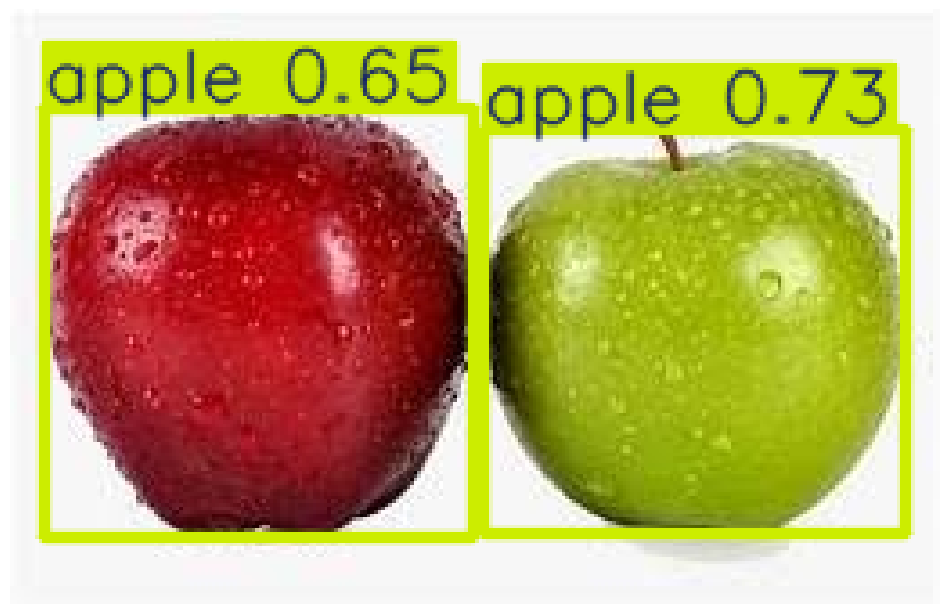

In [32]:
sv.plot_image(annotated_image)

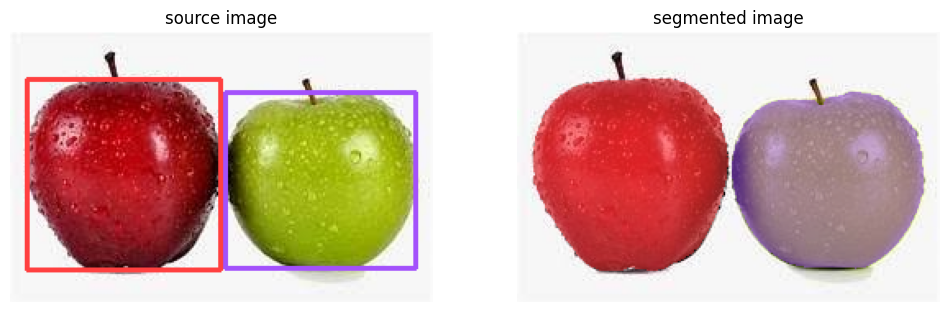

In [33]:
plot_segmentation(image, masks)

In [34]:
obj_colors = get_color(masks, image_rgb)
bg_color = get_bg_color(image_rgb, masks)
print("Object colors:", obj_colors)
print("Background color:", bg_color)

Object colors: [array([162, 183,  16], dtype=uint8), array([179,   8,  14], dtype=uint8)]
Background color: [     242.69      241.92      240.73]


In [35]:
labels_with_colors = list(zip(labels, obj_colors))

# Print the zipped labels and colors
for label, color in labels_with_colors:
    # print(f"Label: {label}, Dominant Color: {color[0]}, Mean Color: {color[1]}")
    print(f"Label: {label}, Dominant Color: {color}")

Label: apple, Dominant Color: [162 183  16]
Label: apple, Dominant Color: [179   8  14]


In [36]:
labels_with_colors = get_color_names(labels, obj_colors)

In [37]:
labels_with_colors

[('apple', 'Green'), ('apple', 'Red')]

In [38]:
prompt = gen_prompt(labels_with_colors, bg_color)

In [38]:
prompt 

'Generate a photorealistic image of two apples, one green and one red, on a white background. \n'

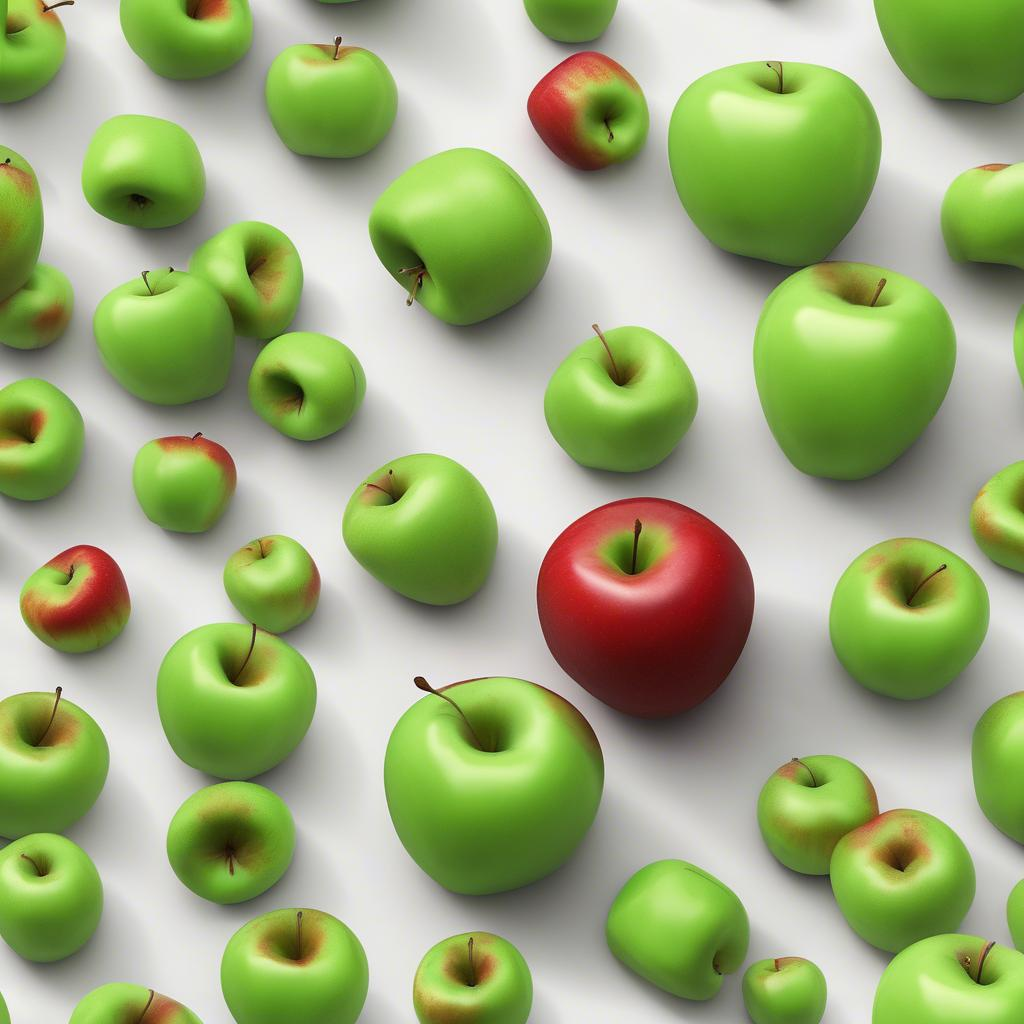

In [51]:
import requests
import base64
from PIL import Image
from io import BytesIO

# Replace with the public URL provided by ngrok in the Colab notebook
api_url = "https://delicate-curiously-halibut.ngrok-free.app/generate_image"
prompt_data = {"prompt": prompt}

# Send POST request
response = requests.post(api_url, json=prompt_data)

if response.status_code == 200:
    response_data = response.json()

    # Assuming the API returns a base64-encoded image
    if 'image' in response_data:
        image_data = response_data['image']
        # Decode the image from base64
        image_bytes = base64.b64decode(image_data)
        image = Image.open(BytesIO(image_bytes))

        # Save or display the image
        image.save("generated_image.png")
        image.show()
    else:
        print("Response:", response_data)
else:
    print(f"Failed to get a response. Status code: {response.status_code}")

In [61]:
Gen_image_path = "generated_image.png"
gen_image = cv2.imread(Gen_image_path)
gen_image_rgb = cv2.cvtColor(gen_image, cv2.COLOR_BGR2RGB)

In [62]:
gen_masks, gen_labels, gen_detections, gen_annotated_image = get_objects(gen_image, Gen_image_path)


0: 416x416 11 apples, 73.6ms
Speed: 6.0ms preprocess, 73.6ms inference, 9.4ms postprocess per image at shape (1, 3, 416, 416)


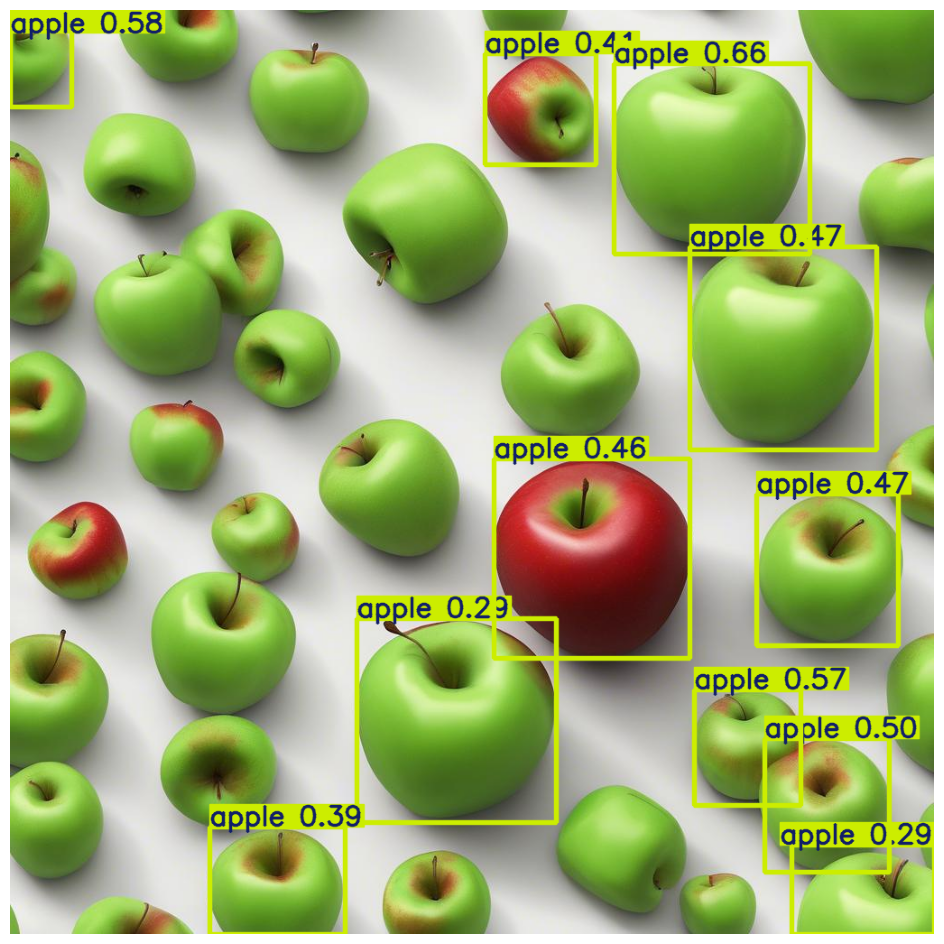

In [63]:
sv.plot_image(gen_annotated_image)

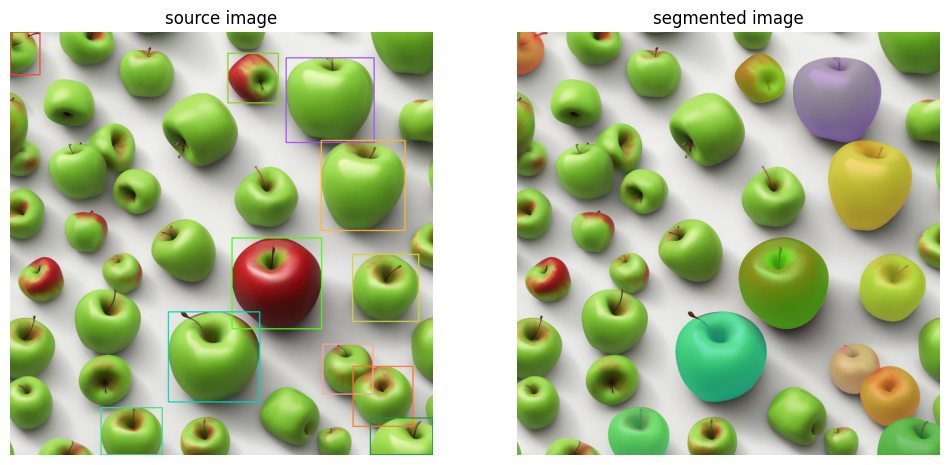

In [64]:
plot_segmentation(gen_image, gen_masks)

In [65]:
gen_obj_colors = get_color(gen_masks, gen_image_rgb)
gen_bg_color = get_bg_color(gen_image_rgb, gen_masks)
print("Object colors:", gen_obj_colors)
print("Background color:", gen_bg_color)

Object colors: [array([112, 175,  44], dtype=uint8), array([138, 201,  71], dtype=uint8), array([160, 215,  88], dtype=uint8), array([ 72, 106,  32], dtype=uint8), array([ 72, 111,  32], dtype=uint8), array([ 73, 109,  37], dtype=uint8), array([63, 17, 17], dtype=uint8), array([124, 171,  65], dtype=uint8), array([ 74, 120,  32], dtype=uint8), array([173, 228, 101], dtype=uint8), array([ 67, 103,  33], dtype=uint8)]
Background color: [     165.23      178.48      139.73]


In [66]:
gen_labels_with_colors = list(zip(gen_labels, gen_obj_colors))

# Print the zipped labels and colors
for label, color in gen_labels_with_colors:
    # print(f"Label: {label}, Dominant Color: {color[0]}, Mean Color: {color[1]}")
    print(f"Label: {label}, Dominant Color: {color}")

Label: apple, Dominant Color: [112 175  44]
Label: apple, Dominant Color: [138 201  71]
Label: apple, Dominant Color: [160 215  88]
Label: apple, Dominant Color: [ 72 106  32]
Label: apple, Dominant Color: [ 72 111  32]
Label: apple, Dominant Color: [ 73 109  37]
Label: apple, Dominant Color: [63 17 17]
Label: apple, Dominant Color: [124 171  65]
Label: apple, Dominant Color: [ 74 120  32]
Label: apple, Dominant Color: [173 228 101]
Label: apple, Dominant Color: [ 67 103  33]


In [67]:
gen_labels_with_colors = get_color_names(gen_labels, gen_obj_colors)

In [68]:
gen_labels_with_colors

[('apple', 'Green'),
 ('apple', 'Green'),
 ('apple', 'Green'),
 ('apple', 'Green'),
 ('apple', 'Green'),
 ('apple', 'Green'),
 ('apple', 'Red'),
 ('apple', 'Green'),
 ('apple', 'Green'),
 ('apple', 'Lime Green'),
 ('apple', 'Green')]

In [69]:
similarity_by_no_objs = calculate_similarity(labels, gen_labels)/100
print(f"Similarity: {similarity_by_no_objs:.4f}")

Similarity: 0.3077


In [70]:
texture_sim = get_texture_sim(image, gen_image, labels_with_colors, gen_labels_with_colors, masks, gen_masks)
print(f"Texture Similarity: {texture_sim:.2f}")

Texture Similarity: 0.40


In [71]:
restnet_sim = get_restnet_sim(IMAGE_PATH, Gen_image_path)
print("Similarity Score:", restnet_sim)


Similarity Score: 0.6470754


In [72]:
import cv2
import numpy as np
from skimage.color import rgb2lab

# Load your images using OpenCV or any image library
image1 = cv2.imread('data/apple.jpg')
image2 = cv2.imread('data/apple.jpg')

# Convert both images from RGB to Lab color space



In [74]:
global_con_sim, diff = compare_global_contrast(image, gen_image)

In [75]:
global_con_sim

0.7917778189943274

In [53]:
diff

0.0

In [76]:
ssim_sim, con_image1, con_image2 = compare_local_contrast(image, gen_image)

In [77]:
ssim_sim

0.007815339121966655

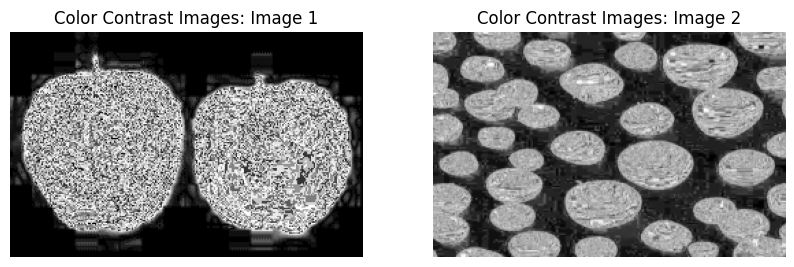

In [79]:
plot_contrast_images(con_image1, con_image2, cmap = "gray", title = 'Color Contrast Images')

In [80]:
similarity_scores = {
    "global_contrast_similarity": global_con_sim,
    "local_contrast_similarity": ssim_sim,
    "label_similarity": similarity_by_no_objs,
    "texture_similarity": texture_sim,
    "restnet_similarity": restnet_sim,
}

weights = {
    "global_contrast_similarity": 0.2,
    "local_contrast_similarity": 0.1,
    "label_similarity": 0.4,
    "texture_similarity": 0.1,
    "restnet_similarity": 0.2,
}

In [81]:
def aggregate_similarity_scores(similarity_scores, weights):
    """
    Aggregate similarity scores with given weights.

    Args:
    similarity_scores (dict): Dictionary of similarity scores with keys as the method names.
    weights (dict): Dictionary of weights for each similarity score with keys as the method names.

    Returns:
    float: Aggregated similarity score.
    """
    if not similarity_scores or not weights:
        raise ValueError("Similarity scores and weights must not be empty.")

    if set(similarity_scores.keys()) != set(weights.keys()):
        raise ValueError("Similarity scores and weights must have the same keys.")
    aggregated_score = 0
    aggregated_score = sum(similarity_scores[method] * weights[method] for method in similarity_scores)
    return aggregated_score

In [82]:
a = aggregate_similarity_scores(similarity_scores, weights)
a

0.4511768761899343

In [83]:
global_con_sim,ssim_sim,similarity_by_no_objs,texture_sim,restnet_sim

(0.7917778189943274,
 0.007815339121966655,
 0.3076923076923077,
 0.3954777247043052,
 0.6470754)